In [1]:
# all libraries used in program 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# examine the base data of clinical
df = pd.read_csv('clinical.csv')
df.head()

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
0,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
1,2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
2,3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
3,4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
4,5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3


In [2]:
df_gene = pd.read_csv('genomics.csv')
df_gene.describe()

,ID
count,510.000000
mean,93.962745
std,55.988602
min,1.000000
25%,47.000000
50%,94.000000
75%,144.000000
max,190.000000


In [3]:
df['ID'].nunique()
# no duplicate records according to ID

190

In [4]:
# end goal is model by survivabilty within one year after diagnosis
# find factors liking with living more than one year and trim that data
df = df.sort_values(by=['Survival.Months'])
df.shape

(190, 16)

In [5]:
# drop the survival months that are less than a year
df1 = df.loc[df['Survival.Months'] >= 12]
df1.describe()
# 60 records were removed from the first criterium

,ID,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,130.000000,130.000000,130.000000,130.000000,130.000000,95.000000,91.000000,130.000000,97.000000,130.000000,130.000000
mean,94.161538,27.669231,70.207692,6.053846,0.307692,0.863158,0.065934,2.153846,4.526804,2.638462,2.976923
std,54.230173,11.395898,5.493754,3.189886,0.463324,1.027396,0.249542,2.485498,3.050359,1.473296,1.731896
min,2.000000,13.000000,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.500000,16.000000,67.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000
50%,91.500000,32.000000,71.000000,9.000000,0.000000,0.000000,0.000000,0.000000,3.600000,2.000000,3.000000
75%,138.750000,36.000000,72.750000,9.000000,1.000000,2.000000,0.000000,5.000000,8.000000,3.000000,4.000000
max,190.000000,71.000000,84.000000,9.000000,1.000000,3.000000,1.000000,5.000000,10.000000,7.000000,8.000000


In [6]:
# replace with missing data indicator NaN to assist in cleaning up incomplete records and for correlation
df1 = df1.replace('UNK', np.nan)
df1['Grade'] = df1['Grade'].replace(9, np.nan)

In [7]:
df1.isna().sum()
# enough grade, M, and Tumor.Size data is missing that I will drop it for now as most of the 
# information is preseved in other variables

ID                    0
Outcome               0
Survival.Months       0
Age                   0
Grade                69
Num.Primaries         0
T                    31
N                    35
M                    39
Radiation             0
Stage                 0
Primary.Site          0
Histology             0
Tumor.Size           33
Num.Mutated.Genes     0
Num.Mutations         0
dtype: int64

In [8]:
# Dropping TNM as all contain too much culminative missing data to build a reliable model
# Dropping Grade as it is missing too much data in the spread for reliablilty
df2 = df1.dropna(subset=['Tumor.Size'])
df2 = df2.drop(columns=['Grade', 'T', 'N', 'M'])

In [9]:
df2.isna().sum()

ID                   0
Outcome              0
Survival.Months      0
Age                  0
Num.Primaries        0
Radiation            0
Stage                0
Primary.Site         0
Histology            0
Tumor.Size           0
Num.Mutated.Genes    0
Num.Mutations        0
dtype: int64

In [10]:
df2.describe()
# 97 remaining rows out of the original 190, just over half of the original data

,ID,Survival.Months,Age,Num.Primaries,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,94.989691,27.752577,70.030928,0.340206,2.061856,4.526804,2.690722,3.041237
std,54.648211,12.122664,5.911595,0.476240,2.474093,3.050359,1.516306,1.784876
min,3.000000,13.000000,56.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,16.000000,67.000000,0.000000,0.000000,2.000000,2.000000,2.000000
50%,95.000000,32.000000,71.000000,0.000000,0.000000,3.600000,2.000000,3.000000
75%,143.000000,36.000000,72.000000,1.000000,5.000000,8.000000,4.000000,4.000000
max,189.000000,71.000000,84.000000,1.000000,5.000000,10.000000,7.000000,8.000000


In [11]:
# fixing typos in Stage and Primary.Site
df2['Stage'].replace(['1B'], ['IB'], inplace = True)
df2['Primary.Site'].replace(['Righ Upper Lobe'], ['Right Upper Lobe'], inplace = True)

In [12]:
# examine remaining data in clinical dataframe
df2.describe()

,ID,Survival.Months,Age,Num.Primaries,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,94.989691,27.752577,70.030928,0.340206,2.061856,4.526804,2.690722,3.041237
std,54.648211,12.122664,5.911595,0.476240,2.474093,3.050359,1.516306,1.784876
min,3.000000,13.000000,56.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,16.000000,67.000000,0.000000,0.000000,2.000000,2.000000,2.000000
50%,95.000000,32.000000,71.000000,0.000000,0.000000,3.600000,2.000000,3.000000
75%,143.000000,36.000000,72.000000,1.000000,5.000000,8.000000,4.000000,4.000000
max,189.000000,71.000000,84.000000,1.000000,5.000000,10.000000,7.000000,8.000000


In [13]:
# remove the ID's removed from cleaning clinical.csv data
a = df2.ID
df_gene = df_gene[df_gene.ID.isin(a)]

In [14]:
# examine the remaining data of genomics
df_gene = df_gene.sort_values(by=['ID'])
df_gene.describe()

,ID
count,261.000000
mean,93.268199
std,54.172347
min,3.000000
25%,42.000000
50%,96.000000
75%,141.000000
max,189.000000


In [15]:
# change Outcome into numerical data
df2.reset_index()
df2['Outcome_Num'] = df2['Outcome']
# change Histology into categorical data: 
'''
0 - Dead
1 - Alive
'''
df2['Outcome_Num'].replace(['Dead', 'Alive'], [0, 1], inplace = True)
df2['Outcome_Num'].value_counts()

0    73
1    24
Name: Outcome_Num, dtype: int64

In [16]:
df2.reset_index()
df2['Primary.Site_Num'] = df2['Primary.Site']
# change Primary Site into numerical data, accounting for the typo: 
'''
1 - Left Lower Lobe
2 - Right Upper Lobe
3 - Right Hilar
4 - Right Lower Lobe
5 - Left Upper Lobe
6 - Both Lung
7 - Right Middle Lobe
'''
df2['Primary.Site_Num'].replace(['Left Lower Lobe', 'Right Upper Lobe', 
                                'Right Hilar', 'Right Lower Lobe', 'Left Upper Lobe', 
                                'Both Lung', 'Right Middle Lobe'], [1, 2, 3, 4, 5, 6, 7], inplace = True)
df2['Primary.Site_Num'].value_counts()

2    38
4    22
5    12
3    12
1     9
6     3
7     1
Name: Primary.Site_Num, dtype: int64

In [17]:
# remove the outliers of Right Middle Lobe and Both Lung
df2 = df2.loc[df2['Primary.Site_Num'] < 6]
df2['Primary.Site_Num'].value_counts()

2    38
4    22
5    12
3    12
1     9
Name: Primary.Site_Num, dtype: int64

In [18]:
df2.reset_index()
df2['Histology_Num'] = df2['Histology']
# change Histology into numerical data: 
'''
1 - Squamous cell carcinoma
2 - Adenocarcinoma
3 - Large-cell carcinoma
'''
df2['Histology_Num'].replace(['Squamous cell carcinoma', 'Adenocarcinoma', 'Large-cell carcinoma'], [1, 2, 3], inplace = True)
df2['Histology_Num'].value_counts()

1    50
2    42
3     1
Name: Histology_Num, dtype: int64

In [19]:
# remove the outlier of Large-cell carcinoma
df2 = df2.loc[df2['Histology_Num'] < 3]
df2['Histology_Num'].value_counts()

1    50
2    42
Name: Histology_Num, dtype: int64

In [20]:
df2.reset_index()
df2['Stage_Num'] = df2['Stage']
# change Primary Site into numerical data, accounting for the typo: 
'''
1 - IA, IB
2 - IIA, IIB
3 - IIIA, IIIB
4 - IV, IVB
'''
df2['Stage_Num'].replace(['IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV', 'IVB'],
                         [1, 1, 2, 2, 3, 3, 4, 4], inplace = True)
df2['Stage_Num'].value_counts()

4    34
3    23
1    23
2    12
Name: Stage_Num, dtype: int64

In [21]:
df2.describe()
# OBSERVATIONS:
# Average age is 70, between 64 and 76
# Most tumor grades were missing
# Average follow up time is 2 years with an average of 1 year
# Most paitents didn't have primary tumors
# Most didn't have radiation
# Most tumors were 1 to 7 inches in size
# Most paitents had 3 mutations and mutated genes
# Most paitents had died, 78.4%

,ID,Survival.Months,Age,Num.Primaries,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Outcome_Num,Primary.Site_Num,Histology_Num,Stage_Num
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,96.293478,27.630435,70.032609,0.347826,2.119565,4.495652,2.630435,2.956522,0.250000,2.880435,1.456522,2.739130
std,55.080468,12.298233,5.987994,0.478890,2.484424,3.054124,1.465481,1.683227,0.435385,1.247788,0.500835,1.203197
min,3.000000,13.000000,56.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,49.500000,16.000000,67.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,1.750000
50%,96.500000,32.000000,71.000000,0.000000,0.000000,3.600000,2.000000,3.000000,0.000000,2.000000,1.000000,3.000000
75%,145.250000,36.000000,72.000000,1.000000,5.000000,8.125000,3.000000,4.000000,0.250000,4.000000,2.000000,4.000000
max,189.000000,71.000000,84.000000,1.000000,5.000000,10.000000,7.000000,7.000000,1.000000,5.000000,2.000000,4.000000


In [22]:
# Seems to be outliers in Survival.Months
df2['Survival.Months'].value_counts()

13.0    18
36.0     9
32.0     8
38.0     7
16.0     7
22.0     5
33.0     5
35.0     5
19.0     4
23.0     4
15.0     4
42.0     3
39.0     2
34.0     2
29.0     2
71.0     2
37.0     1
41.0     1
26.0     1
46.0     1
50.0     1
Name: Survival.Months, dtype: int64

In [23]:
# removing outliers in Survival.Months of 71
df2 = df2.loc[df2['Survival.Months'] < 51]

In [24]:
df2.describe()

,ID,Survival.Months,Age,Num.Primaries,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Outcome_Num,Primary.Site_Num,Histology_Num,Stage_Num
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,95.866667,26.666667,69.977778,0.344444,2.111111,4.556667,2.611111,2.944444,0.255556,2.888889,1.444444,2.744444
std,55.617312,10.556429,6.042876,0.477849,2.483403,3.059854,1.458755,1.685104,0.438617,1.258182,0.499688,1.195132
min,3.000000,13.000000,56.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,48.500000,16.000000,67.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000
50%,95.500000,30.500000,71.000000,0.000000,0.000000,3.600000,2.000000,3.000000,0.000000,2.000000,1.000000,3.000000
75%,145.750000,36.000000,72.000000,1.000000,5.000000,8.375000,3.000000,4.000000,0.750000,4.000000,2.000000,4.000000
max,189.000000,50.000000,84.000000,1.000000,5.000000,10.000000,7.000000,7.000000,1.000000,5.000000,2.000000,4.000000


In [25]:
df2.dtypes

ID                     int64
Outcome               object
Survival.Months      float64
Age                    int64
Num.Primaries          int64
Radiation              int64
Stage                 object
Primary.Site          object
Histology             object
Tumor.Size           float64
Num.Mutated.Genes      int64
Num.Mutations          int64
Outcome_Num            int64
Primary.Site_Num       int64
Histology_Num          int64
Stage_Num              int64
dtype: object

In [26]:
correlation=df2[['Survival.Months', 'Age', 'Num.Primaries', 'Radiation', 'Tumor.Size', 'Num.Mutated.Genes',
                'Num.Mutations', 'Outcome_Num', 'Primary.Site_Num', 'Histology_Num', 'Stage_Num']]
correlation.corr()

,Survival.Months,Age,Num.Primaries,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Outcome_Num,Primary.Site_Num,Histology_Num,Stage_Num
Survival.Months,1.000000,0.168445,0.049746,-0.167866,-0.062370,-0.002675,-0.035161,0.431136,-0.001974,0.002840,-0.421842
Age,0.168445,1.000000,-0.079033,-0.090429,-0.097097,0.131570,0.148839,0.184451,-0.035796,0.010750,-0.189046
Num.Primaries,0.049746,-0.079033,1.000000,0.090475,-0.081892,-0.095818,-0.059691,0.272212,-0.047760,-0.224826,-0.139252
Radiation,-0.167866,-0.090429,0.090475,1.000000,0.092760,0.012062,-0.011933,-0.088252,0.075916,-0.040242,0.202746
Tumor.Size,-0.062370,-0.097097,-0.081892,0.092760,1.000000,0.080258,0.091487,-0.314811,-0.092615,0.038458,0.100174
Num.Mutated.Genes,-0.002675,0.131570,-0.095818,0.012062,0.080258,1.000000,0.928145,-0.000976,-0.115635,-0.022265,-0.109204
Num.Mutations,-0.035161,0.148839,-0.059691,-0.011933,0.091487,0.928145,1.000000,0.019425,-0.146032,0.029653,-0.152187
Outcome_Num,0.431136,0.184451,0.272212,-0.088252,-0.314811,-0.000976,0.019425,1.000000,-0.110850,-0.062658,-0.324134
Primary.Site_Num,-0.001974,-0.035796,-0.047760,0.075916,-0.092615,-0.115635,-0.146032,-0.110850,1.000000,-0.170775,0.302211
Histology_Num,0.002840,0.010750,-0.224826,-0.040242,0.038458,-0.022265,0.029653,-0.062658,-0.170775,1.000000,0.004181


'\nSurvival.Months and Outcome_Num +\nSurvival.Months and Stage_Num -\nNum.Primaries and Outcome_Num +\nTumor.Size and Outcome_Num -\nOutcome_Num and Stage_Num -\nPrimary.Site_Num and Stage_Num +\n'

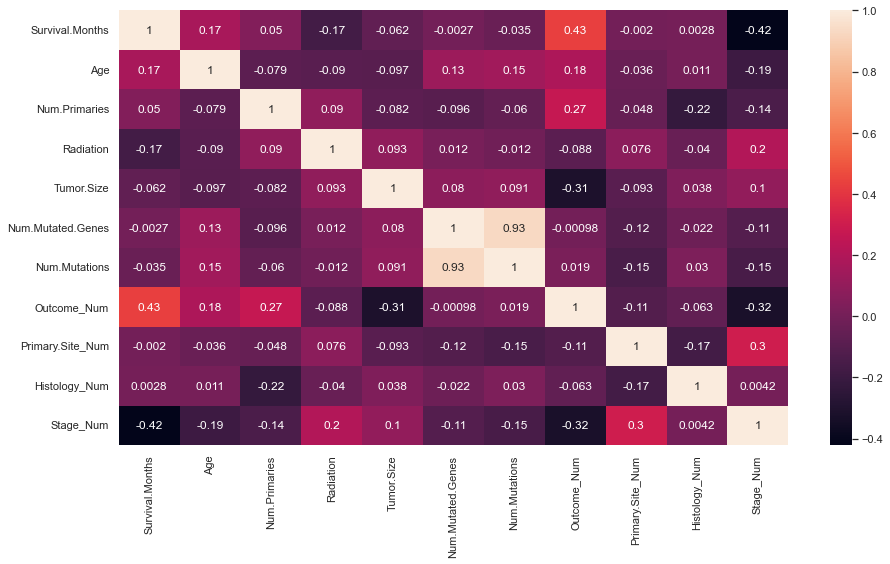

In [27]:
# create heatmap
sns.set(rc={'figure.figsize':(15,8)})
sns.heatmap(correlation.corr(),annot=True);
'''
Survival.Months and Outcome_Num +
Survival.Months and Stage_Num -
Num.Primaries and Outcome_Num +
Tumor.Size and Outcome_Num -
Outcome_Num and Stage_Num -
Primary.Site_Num and Stage_Num +
'''

<AxesSubplot:ylabel='Survival.Months,Outcome'>

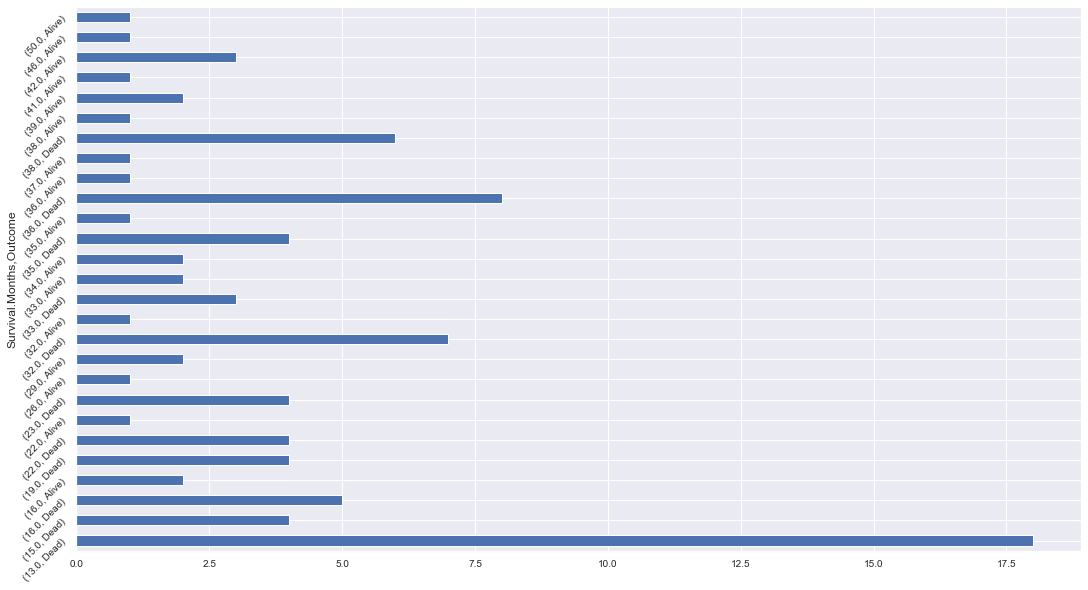

In [28]:
df2.groupby('Survival.Months')['Outcome'].value_counts().plot(kind='barh', rot=45, fontsize=10, figsize=(18, 10))

<AxesSubplot:ylabel='Survival.Months,Radiation'>

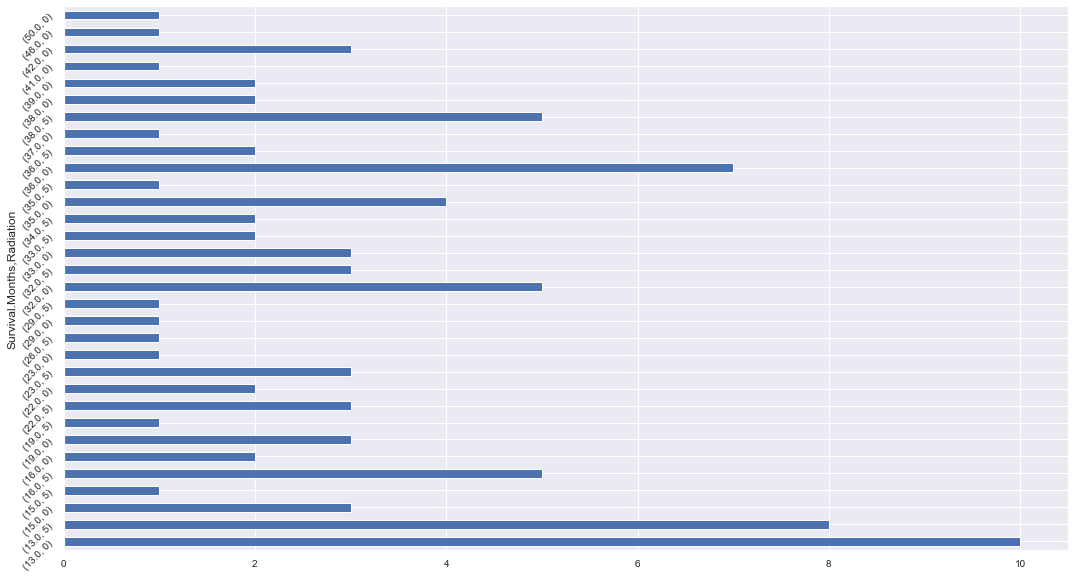

In [29]:
df2.groupby('Survival.Months')['Radiation'].value_counts().plot(kind='barh', rot=45, fontsize=10, figsize=(18, 10))

<AxesSubplot:ylabel='Outcome,Radiation'>

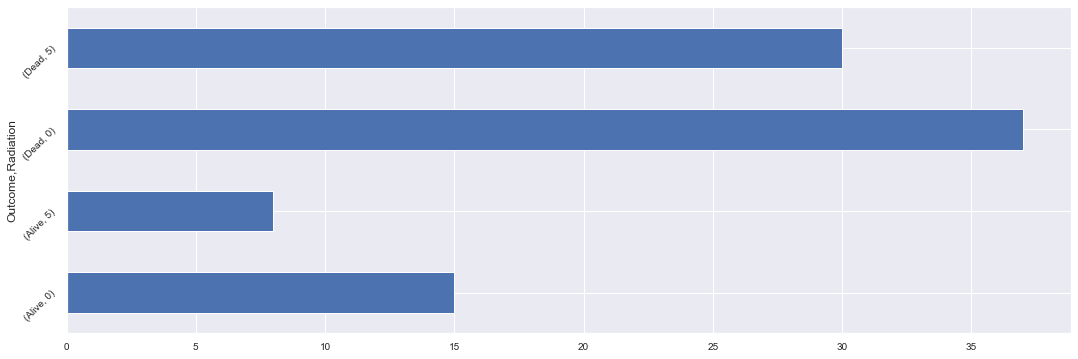

In [30]:
df2.groupby('Outcome')['Radiation'].value_counts().plot(kind='barh', rot=45, fontsize=10, figsize=(18, 6))

Survival.Months
13.0    AxesSubplot(0.125,0.125;0.775x0.755)
15.0    AxesSubplot(0.125,0.125;0.775x0.755)
16.0    AxesSubplot(0.125,0.125;0.775x0.755)
19.0    AxesSubplot(0.125,0.125;0.775x0.755)
22.0    AxesSubplot(0.125,0.125;0.775x0.755)
23.0    AxesSubplot(0.125,0.125;0.775x0.755)
26.0    AxesSubplot(0.125,0.125;0.775x0.755)
29.0    AxesSubplot(0.125,0.125;0.775x0.755)
32.0    AxesSubplot(0.125,0.125;0.775x0.755)
33.0    AxesSubplot(0.125,0.125;0.775x0.755)
34.0    AxesSubplot(0.125,0.125;0.775x0.755)
35.0    AxesSubplot(0.125,0.125;0.775x0.755)
36.0    AxesSubplot(0.125,0.125;0.775x0.755)
37.0    AxesSubplot(0.125,0.125;0.775x0.755)
38.0    AxesSubplot(0.125,0.125;0.775x0.755)
39.0    AxesSubplot(0.125,0.125;0.775x0.755)
41.0    AxesSubplot(0.125,0.125;0.775x0.755)
42.0    AxesSubplot(0.125,0.125;0.775x0.755)
46.0    AxesSubplot(0.125,0.125;0.775x0.755)
50.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

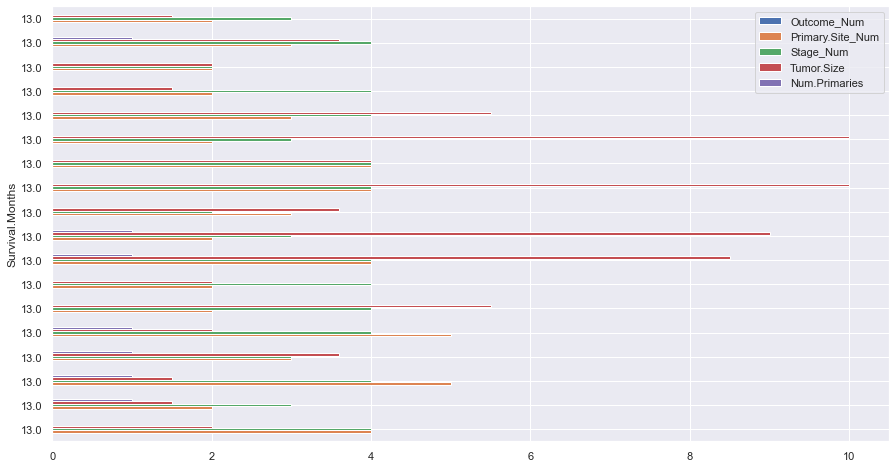

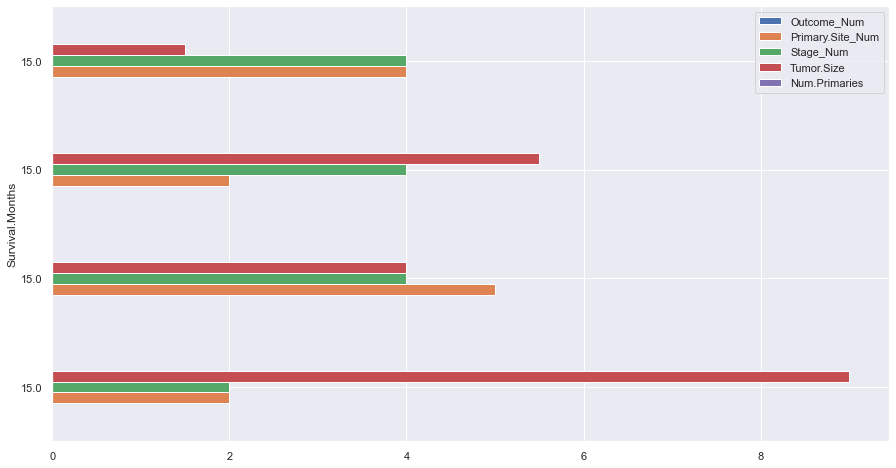

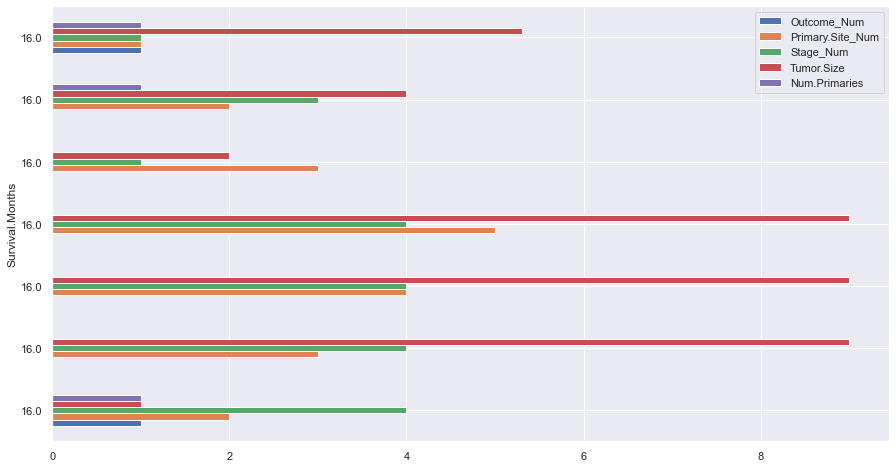

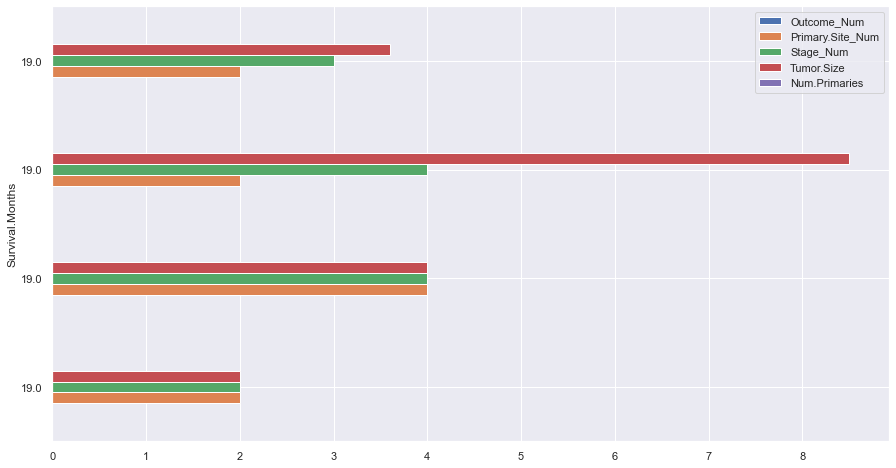

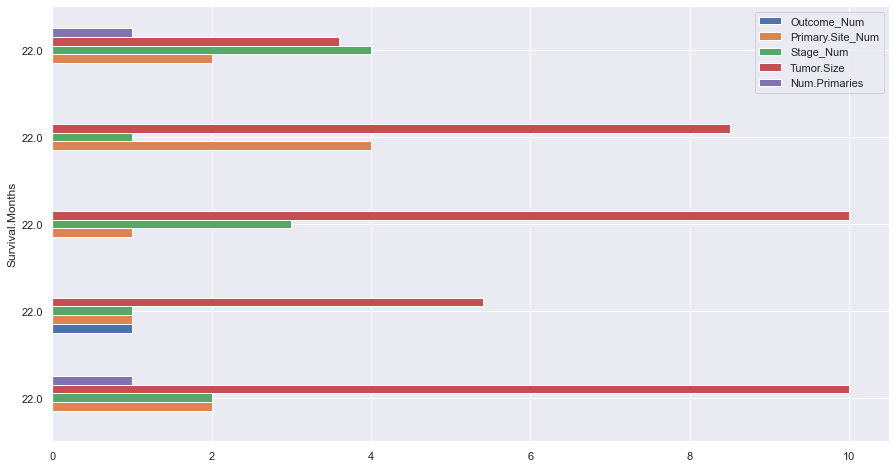

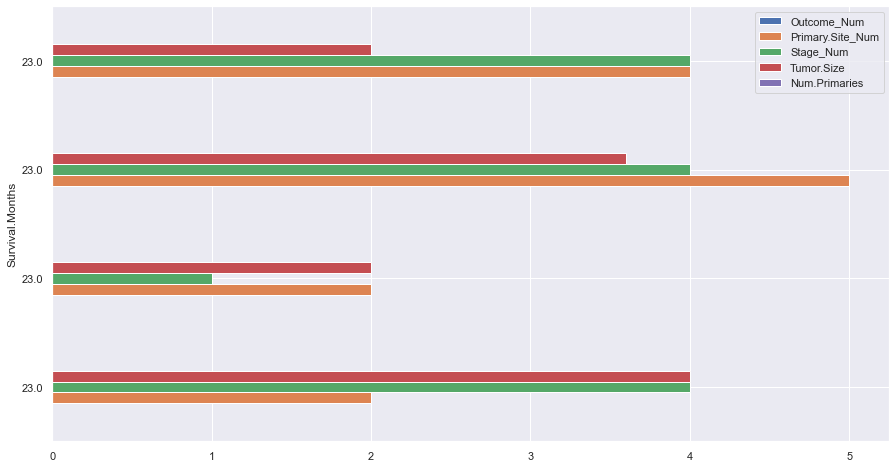

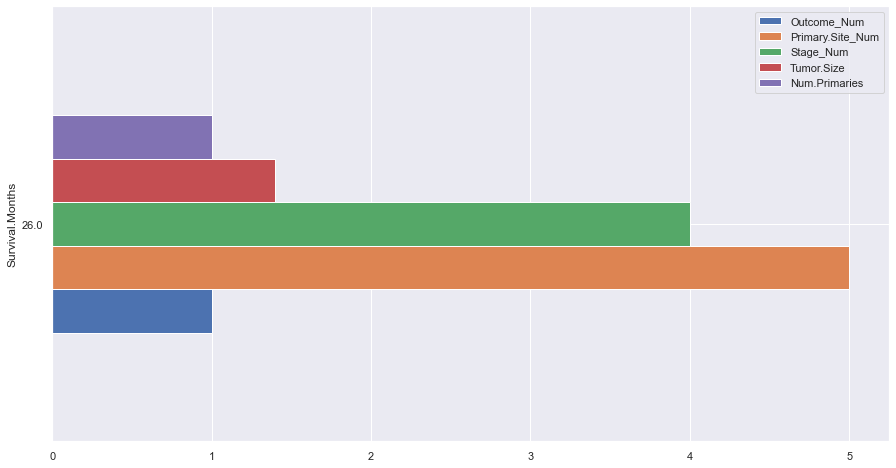

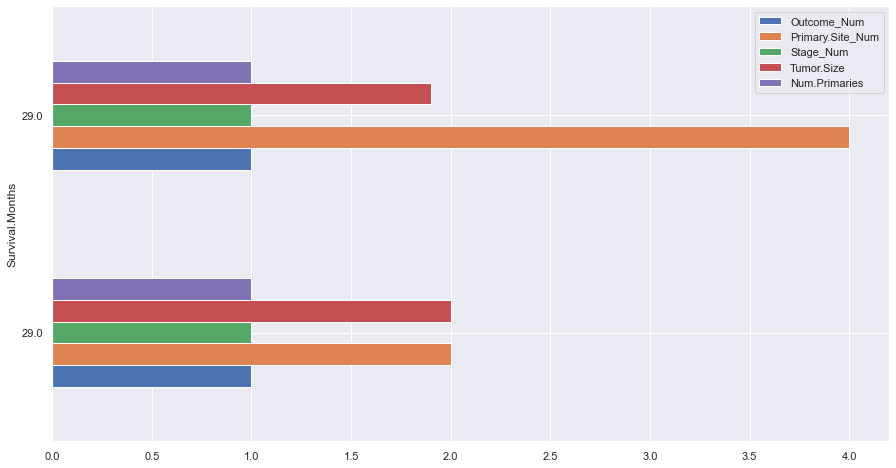

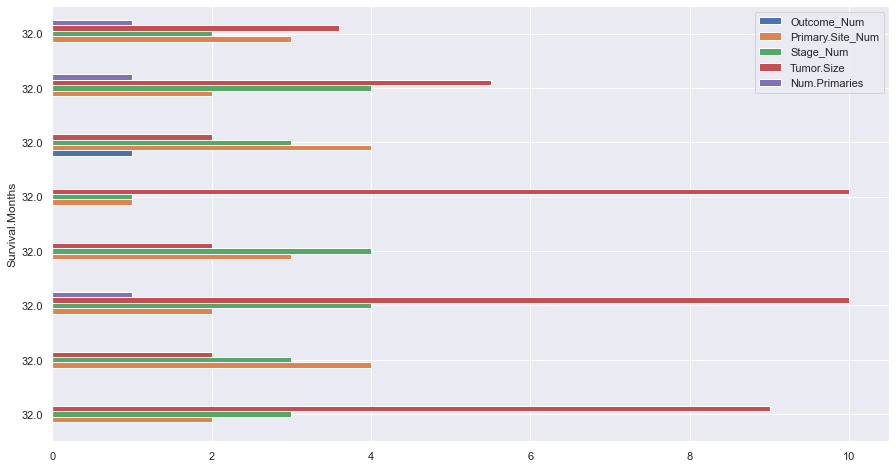

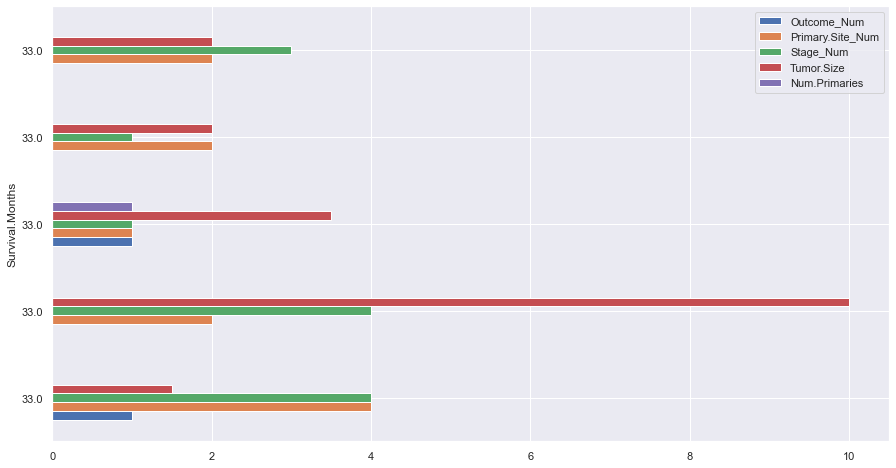

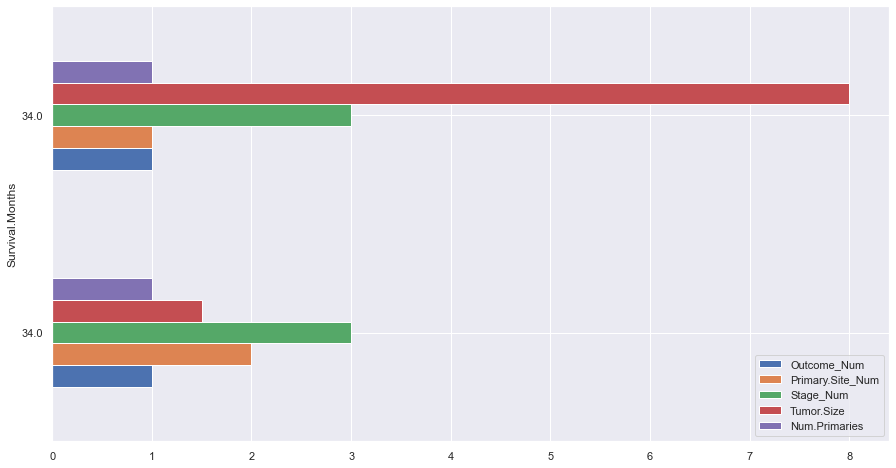

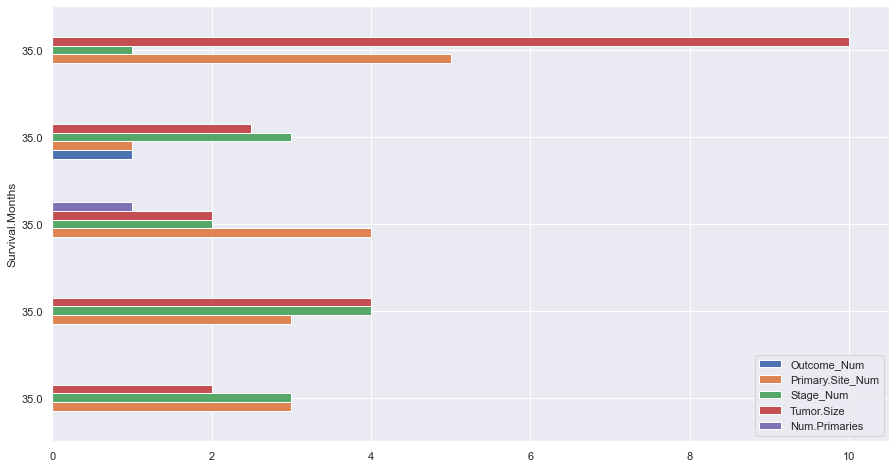

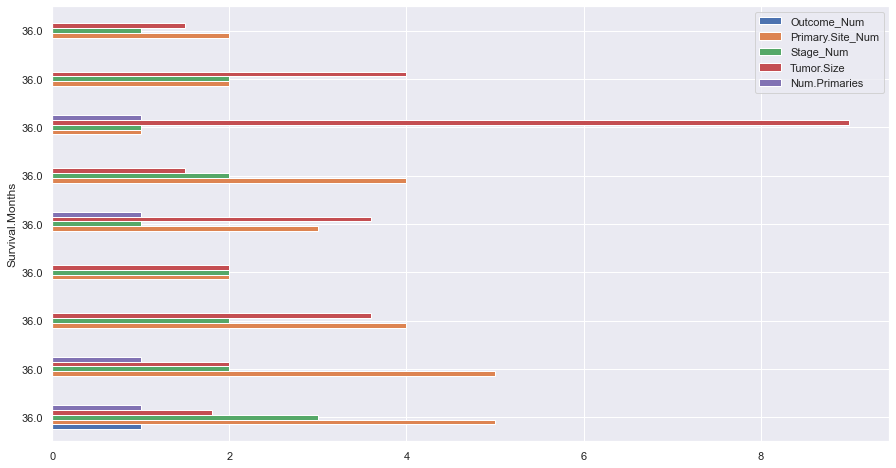

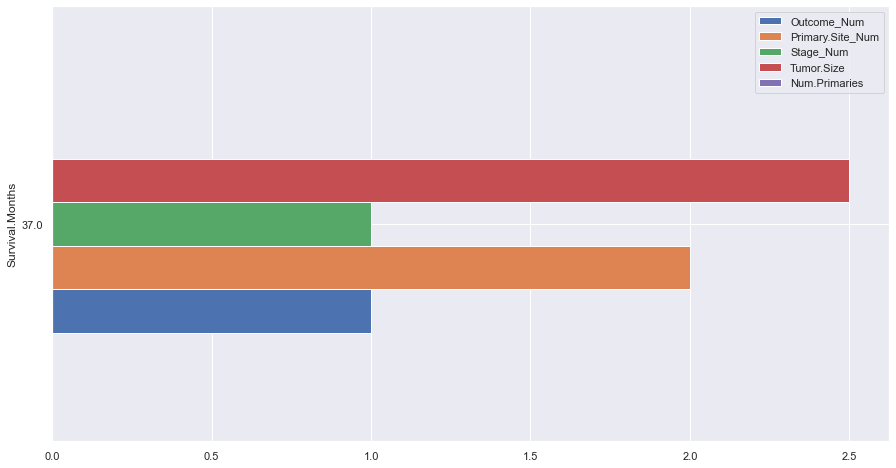

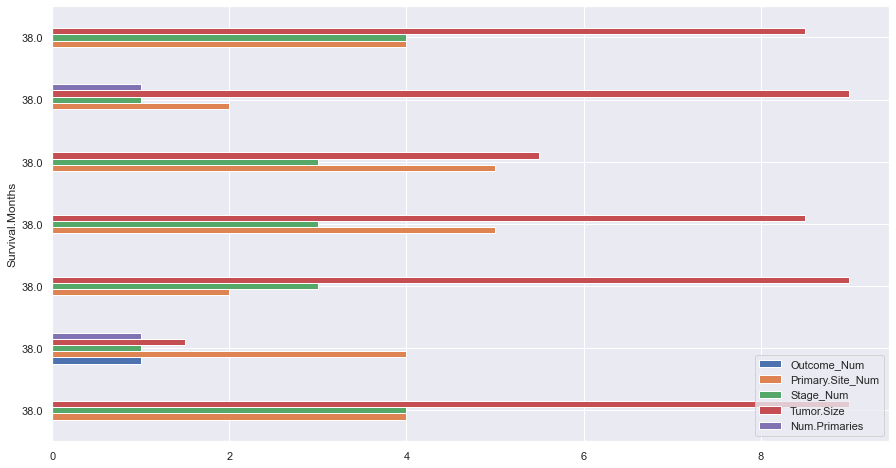

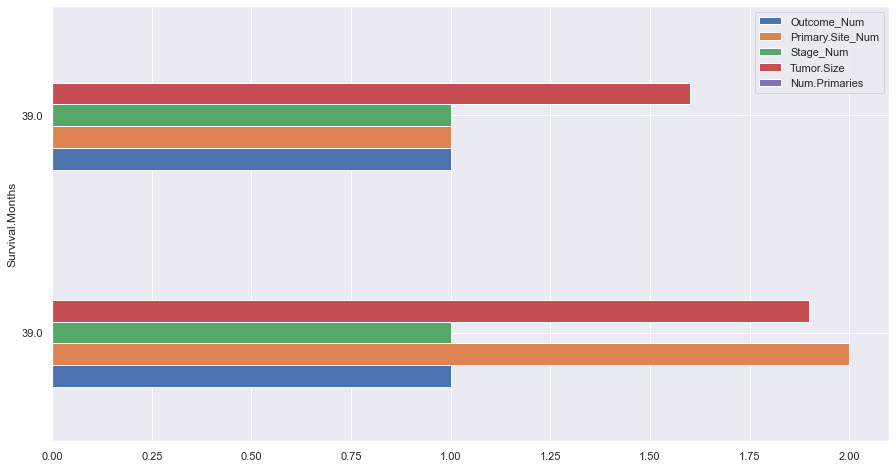

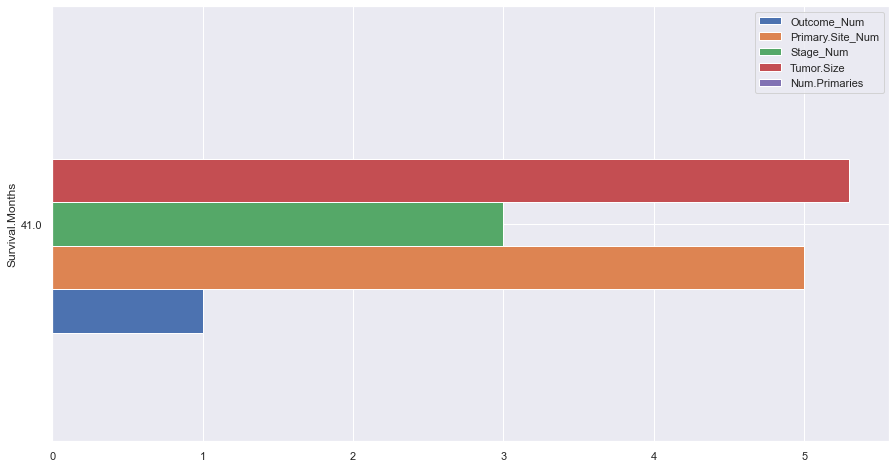

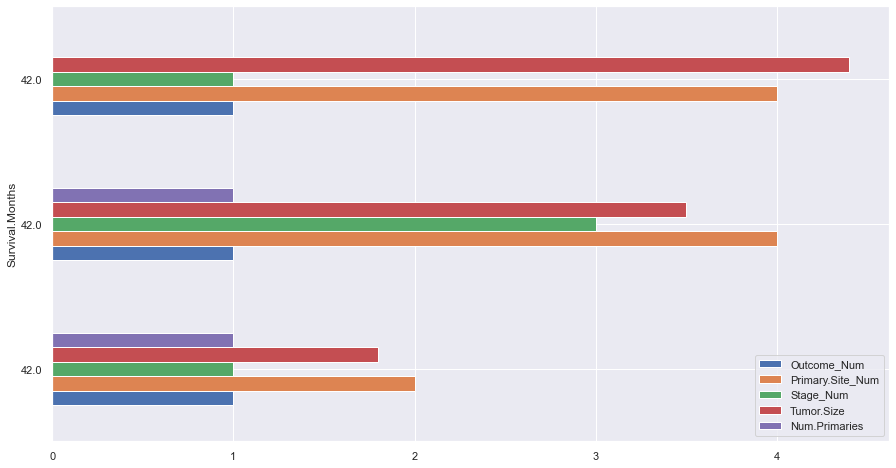

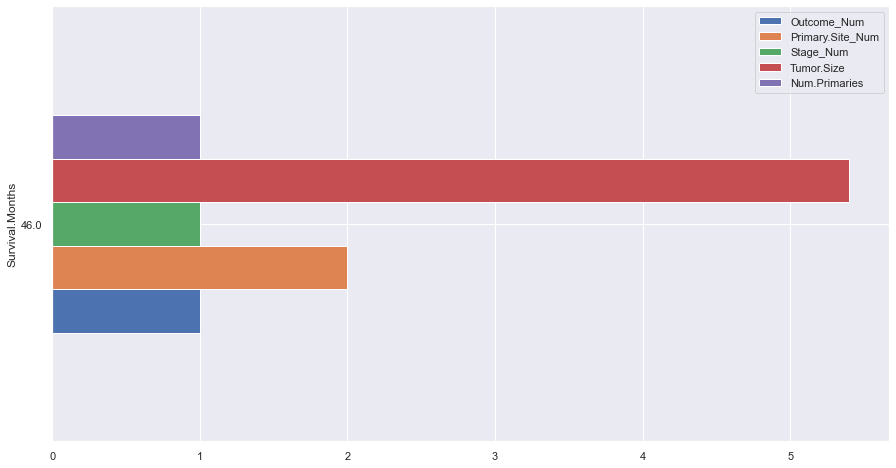

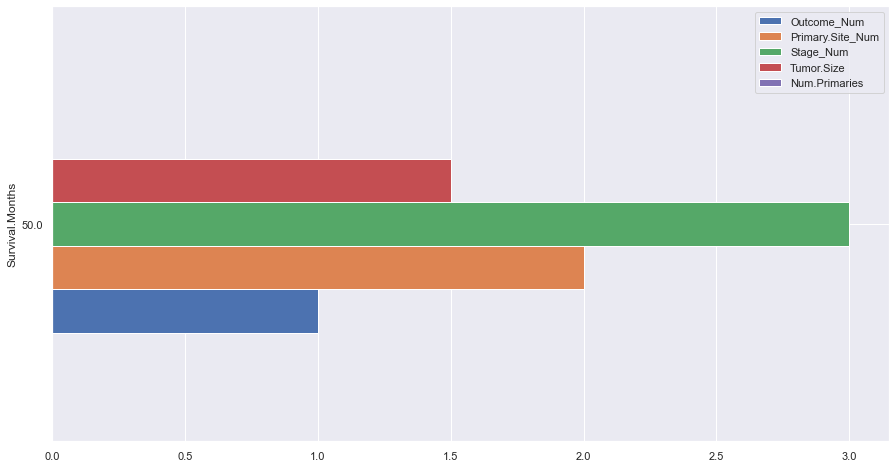

In [31]:
# compare survival months to outcome, mutated genomes (check number then specific genomes), primary.site, histology
df2.groupby('Survival.Months').plot(x='Survival.Months', y=['Outcome_Num', 'Primary.Site_Num', 
                                    'Stage_Num', 'Tumor.Size', 'Num.Primaries'], kind = 'barh')

In [32]:
df2.head()

,ID,Outcome,Survival.Months,Age,Num.Primaries,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,Outcome_Num,Primary.Site_Num,Histology_Num,Stage_Num
98,99,Dead,13.0,63,0,0,IV,Right Lower Lobe,Squamous cell carcinoma,2.0,3,3,0,4,1,4
142,143,Dead,13.0,67,1,5,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,0,2,2,3
75,76,Dead,13.0,73,1,0,IV,Left Upper Lobe,Adenocarcinoma,1.5,1,1,0,5,2,4
117,118,Dead,13.0,72,1,0,IIIB,Right Hilar,Squamous cell carcinoma,3.6,3,3,0,3,1,3
144,145,Dead,13.0,69,1,5,IV,Left Upper Lobe,Adenocarcinoma,2.0,3,3,0,5,2,4


In [33]:
# Machine Learning Bulding a Model, creating test and training data
y = df2['Survival.Months']
X = df2.drop(['ID', 'Outcome', 'Survival.Months', 'Age', 'Radiation', 'Stage', 'Primary.Site', 'Histology',
             'Num.Mutated.Genes', 'Num.Mutations', 'Histology_Num'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [34]:
et = ExtraTreeRegressor()
et.fit(X_train, y_train)
y_et_train_pred = et.predict(X_train)
y_et_test_pred = et.predict(X_test)
et_train_mse = mean_squared_error(y_train, y_et_train_pred)
et_train_r2 = r2_score(y_train, y_et_train_pred)
et_test_mse = mean_squared_error(y_test, y_et_test_pred)
et_test_r2 = r2_score(y_test, y_et_test_pred)
et_results = pd.DataFrame(['Random forest Extra',et_train_mse, et_train_r2, et_test_mse, et_test_r2]).transpose()
et_results.columns = ['Method','Training MSE','Training R2','Test MSE','Test R2']
et_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random forest Extra,7.842593,0.929298,196.888889,-1.016182


Text(0.5, 0, 'Experimental LogS')

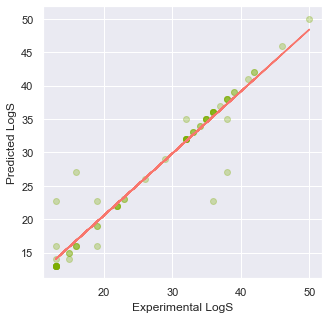

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_et_train_pred, c="#7CAE00", alpha=0.3)
z = np.polyfit(y_train, y_et_train_pred, 1)
p = np.poly1d(z)
plt.plot(y_train,p(y_train),"#F8766D")
plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')